# The Housing Market Shortfall
I theorise that the current number of employees in the construction sector is not enough to fill the current housing shortfall. Furthermore, I theorise that this labour shortfall is large enough that an alternative means to construct housing is needed, as the shortfall will not disappear fast enough.

This document was not created by an economist, and is not intended to be used an accurate assessment of the New Zealand housing situation (if such an assessment could be made). Rather, it is intended as a heuristic of sorts, to roughly gauge supply and demand, and document some of the assumptions that will be the basis for later decisions.

## 1 Demand

In [this Nov 2017 statement](https://www.parliament.nz/en/pb/hansard-debates/rhr/document/HansS_20171109_051150000/2-housing-shortfall-estimate), the New Zealand Minister of Housing and Urban Development, Phil Twyford stated that: "The official figures show a shortfall of 71,000 homes, with a shortage of 45,000 homes in Auckland"

Based off the below graph from BCITO, we can guess that this shortfall is currently stable, given the current supply of construction workforce.

**Shortfall of construction employees, BCITO data**

Based on 6.58 builds per 1,000 population. Presented by BCITO CE Warwick Quinn at 2018 FTMA conference 

## 2 Supply
To find the supply of housing I will find the number of dwelling building consents (total, generated by any sector) per employee in the construction sector, historically.

This can then be used to find how many *new* employees in the construction sector it would take to furfil the estimated shortfall.

* Construction industry population data - [Stats NZ Infoshare tool](http://archive.stats.govt.nz/infoshare/), Household Labour Force Survey (HLF), Persons Employed by Sex by Industry, ANZSIC06 (Annual-Dec)
    * Industry - Construction
    * Sex - Total Both Sexes
    * Time - 2003 to 2018 (all available)
* Building consent data - [Stats NZ Infoshare tool](http://archive.stats.govt.nz/infoshare/), Industry sectors, Building Consents (BLD), Building consents by institutional sector
    * Institutional Sector - Total all sectors
    * Building Type - All buildings, Residential buildings, Dwelling units
    * Building Nature - New
    * Observations - Number, Floor area
    * Time - 2003M01 to 2018M12
    
See `.tqx` files for infoshare table queries that produced this data.

In [82]:
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.axes as Axes
import scipy.ndimage

In [83]:
old_consents_file_path = 'BLD468901_20190413_033516_97.csv'
new_consents_file_path = 'consents_data.csv'

with open(old_consents_file_path,'r') as consents_file:
    
    # Remove unneeded lines 
    lines = consents_file.readlines()
    lines_no_desc = lines[5:-31]
    
    # Write to CSV file
    with open(new_consents_file_path, 'w') as new_consents_file:
        new_consents_file.writelines(lines_no_desc)

In [84]:
# Import consent data, with column names
consents = pd.read_csv(new_consents_file_path, header=None, names=[
    'Time', 
    'All buildings, Number', 'All buildings, Floor area',
    'Residential buildings, Number', 'Residential buildings, Floor area',
    'Dwelling units, Number', 'Dwelling units, Floor area'
])

# Convert StatsNZ date time to Pandas datetime data
consents[['Time']] = consents.apply(lambda x: pd.Series([pd.to_datetime(x['Time'], format='%YM%m')]), axis=1)

# Set datetime as index
consents = consents.set_index('Time')

# Set freq to annually
consents = consents.resample("Y").sum()
consents.index = consents.index.year

consents.head()

All buildings, Number  All buildings, Floor area  \
Time                                                     
2003                  37289                    8614314   
2004                  39905                    9431850   
2005                  34345                    8722271   
2006                  34231                    8077112   
2007                  33867                    8565415   

      Residential buildings, Number  Residential buildings, Floor area  \
Time                                                                     
2003                          29914                            5523797   
2004                          31423                            5664582   
2005                          26023                            4965783   
2006                          25952                            4967159   
2007                          25590                            5021487   

      Dwelling units, Number  Dwelling units, Floor area  
Time                                                      
2003                   29914                     5523797  
2004                   31423                     5664582  
2005                   26023                     4965783  
2006                   25952                     4967159  
2007                   25590                     5021487

In [85]:
# Need to fix all this for new dataset

old_employment_file_path = 'HLF347805_20190412_035628_10.csv'
new_employment_file_path = 'employment_data.csv'

with open(old_employment_file_path,'r') as employment_file:
    
    # Remove unneeded lines 
    lines = employment_file.readlines()
    lines_no_desc = lines[3:-29]
    
    # Write to CSV file
    with open(new_employment_file_path, 'w') as new_employment_file:
        new_employment_file.writelines(lines_no_desc)

In [86]:
# Import construction employment data
employment = pd.read_csv(new_employment_file_path, header=None, names=['Time','Employed (000)'])

# Multiply employed by 1000
employment['Employed'] = employment['Employed (000)'] * 1000
del employment['Employed (000)']

# Convert StatsNZ data time to Pandas datetime data
employment[['Time']] = employment.apply(lambda x: pd.Series([pd.to_datetime(x['Time'], format='%Y')]), axis=1)

# Set datetime as index
employment = employment.set_index('Time')

# Set year as index
employment.index = employment.index.year

employment.head()

Employed
Time          
2003  144400.0
2004  156900.0
2005  166900.0
2006  189200.0
2007  189300.0

In [87]:
# Merge datasets
#construction_data = consents.merge(employment, how='inner', left_index=True, right_index=True)
construction_data = consents.merge(employment, left_index=True, right_index=True)

construction_data.head()

All buildings, Number  All buildings, Floor area  \
Time                                                     
2003                  37289                    8614314   
2004                  39905                    9431850   
2005                  34345                    8722271   
2006                  34231                    8077112   
2007                  33867                    8565415   

      Residential buildings, Number  Residential buildings, Floor area  \
Time                                                                     
2003                          29914                            5523797   
2004                          31423                            5664582   
2005                          26023                            4965783   
2006                          25952                            4967159   
2007                          25590                            5021487   

      Dwelling units, Number  Dwelling units, Floor area  Employed  
Time                                                                
2003                   29914                     5523797  144400.0  
2004                   31423                     5664582  156900.0  
2005                   26023                     4965783  166900.0  
2006                   25952                     4967159  189200.0  
2007                   25590                     5021487  189300.0

In [88]:
# Find dwelling unit consents per employed person

construction_data['Annual consents per employed'] = construction_data.apply(
    lambda x: float(x['Dwelling units, Number'])/float(x['Employed']),
    axis=1
)

construction_data.head()

All buildings, Number  All buildings, Floor area  \
Time                                                     
2003                  37289                    8614314   
2004                  39905                    9431850   
2005                  34345                    8722271   
2006                  34231                    8077112   
2007                  33867                    8565415   

      Residential buildings, Number  Residential buildings, Floor area  \
Time                                                                     
2003                          29914                            5523797   
2004                          31423                            5664582   
2005                          26023                            4965783   
2006                          25952                            4967159   
2007                          25590                            5021487   

      Dwelling units, Number  Dwelling units, Floor area  Employed  \
Time                                                                 
2003                   29914                     5523797  144400.0   
2004                   31423                     5664582  156900.0   
2005                   26023                     4965783  166900.0   
2006                   25952                     4967159  189200.0   
2007                   25590                     5021487  189300.0   

      Annual consents per employed  
Time                                
2003                      0.207161  
2004                      0.200274  
2005                      0.155920  
2006                      0.137167  
2007                      0.135182

In [89]:
# Get mean annual consents per employed
mean_annual_consents = construction_data['Annual consents per employed'].mean()

print("Mean annual consents per employed = " + str(mean_annual_consents))

Mean annual consents per employed = 0.12813609503600648


In [90]:
shortfall = 71000

years_work_required = shortfall/mean_annual_consents

years_available = 10

workers_required = years_work_required/years_available

print(("In order to furfill the current housing shortfall in 10 years, {w}"
       " additional workers are required immediately, to work for 10 years.").format(
    w=int(workers_required)
))

In order to furfill the current housing shortfall in 10 years, 55409 additional workers are required immediately, to work for 10 years.


## 3 Supply meeting demand

We require an additional 71,000 homes. Assuming the current rate of production is keeping the current shortfall of homes stable, this means we need an additional 55,000 workers within the construction industry immediately to resolve the housing crisis in 10 years.

Unfortunately, we cannot acquire 55,000 workers instantly. Rather, they must be trained or imported. We will use the past 3 years' mean growth in the construction workforce as the base for this growth. The speed of workforce growth will change over time. We will use [BCITO's annual growth in completed apprenticeships](https://bcito.org.nz/news-and-publications/annual-reports/) as indicative of the acceleration of workforce growth.

Also, as the New Zealand population grows, the number of homes needed also grows. According to [stats NZ](http://archive.stats.govt.nz/browse_for_stats/population/estimates_and_projections/NationalPopulationProjections_HOTP2016.aspx), the population is expected to grow for the next few decades, with the population growth slowing over time. This population growth increases the number of required dwellings.

In [128]:
period = 3
growth = construction_data["Employed"].iloc[-1] - construction_data["Employed"].iloc[-period]
annual_rate_of_worker_growth = growth / period
print("Annual growth of construction workforce: {}".format(annual_rate_of_worker_growth))

Annual growth of construction workforce: 5000.0


In [129]:
bcito_completions_14_to_17 = [1715, 2018, 2343, 2379] # Source: https://bcito.org.nz/news-and-publications/annual-reports/
growths = []
for i in range(len(bcito_completions_14_to_17))[1:]:
    growth = bcito_completions_14_to_17[i] / bcito_completions_14_to_17[i-1]
    growths.append(growth)
    
worker_growth_acceleration = sum(growths) / len(growths)
print("Annual increase in speed of construction workforce growth: {}%".format(worker_growth_acceleration*100-100))

Annual increase in speed of construction workforce growth: 11.769728223572343%


In [130]:
# Annual population change data
# Source: http://archive.stats.govt.nz/browse_for_stats/population/estimates_and_projections/NationalPopulationProjections_HOTP2016.aspx
pop_change_years = [2018, 2023, 2028, 2033, 2038, 2043, 2048]
pop_change_years = [y - 2018 for y in pop_change_years]

pop_change_data_000 = [82, 48, 45, 38, 33, 29, 26]
pop_change_data = [d*1000 for d in pop_change_data_000]

projected_pop_change = pd.Series(data=pop_change_data, index=pop_change_years)
projected_pop_change = projected_pop_change.reindex(range(pop_change_years[-1]))
projected_pop_change = projected_pop_change.interpolate(method="linear")

mean_person_per_household = 2.7 # Source: http://archive.stats.govt.nz/browse_for_stats/population/estimates_and_projections/dwellings-household-trends-1991-2015.aspx
pop_change_fte = lambda y: (projected_pop_change.iloc[y]/mean_person_per_household)/mean_annual_consents
print(("In the first year, the population change will require {} "
       "additional years FTE, in the 10th year it will require {}.").format(
        pop_change_fte(1), pop_change_fte(10)
))

In the first year, the population change will require 217361.48463105128 additional years FTE, in the 10th year it will require 130070.03734570887.


In [131]:
remaining_years_work = years_work_required
base_year = 2018
year = 0
base_workers = construction_data["Employed"].iloc[-1]
surplus_workers = 0
current_worker_growth_rate = annual_rate_of_worker_growth

shortfall_data = {"Remaining FTE, years": [],
                  "Construction workforce": []}
year_index = []

while remaining_years_work > 0:
    year += 1
    year_index.append(year + base_year)
    
    current_worker_growth_rate = current_worker_growth_rate * worker_growth_acceleration
    surplus_workers += current_worker_growth_rate
    shortfall_data["Construction workforce"].append(base_workers + surplus_workers)
    
    remaining_years_work += pop_change_fte(year)
    remaining_years_work -= surplus_workers
    
    shortfall_data["Remaining FTE, years"].append(remaining_years_work)

    
print("Estimated years before housing crisis is resolved: {}".format(year))

Estimated years before housing crisis is resolved: 22


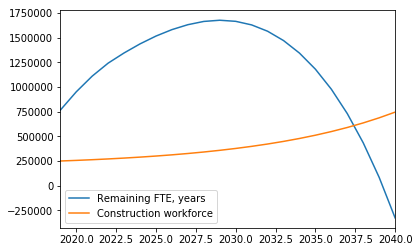

In [132]:
shortfall_df = pd.DataFrame(data=shortfall_data, index=year_index)
shortfall_df.plot.line()

## 4 Conclusion

Based off the above calculations, we can estimate that it will take 22 years for the New Zealand housing crisis to resolve.